# 請先上傳AutoPreprocess.py以及healthcare_train.csv

# 中風預測 分類問題

In [1]:
#載入訓練用資料
import pandas as pd
import numpy as np
data = pd.read_csv('/content/healthcare_train.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,25283,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked,0
1,41917,Female,29.0,0,0,No,Private,Urban,84.19,21.2,never smoked,0
2,36045,Female,35.0,0,0,Yes,Private,Rural,119.40,22.9,never smoked,0
3,28315,Male,38.0,0,0,Yes,Private,Rural,108.68,32.7,never smoked,0
4,26325,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,0


In [2]:
#列出欄位名稱
data.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4087 entries, 0 to 4086
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4087 non-null   int64  
 1   gender             4087 non-null   object 
 2   age                4087 non-null   float64
 3   hypertension       4087 non-null   int64  
 4   heart_disease      4087 non-null   int64  
 5   ever_married       4087 non-null   object 
 6   work_type          4087 non-null   object 
 7   Residence_type     4087 non-null   object 
 8   avg_glucose_level  4087 non-null   float64
 9   bmi                3924 non-null   float64
 10  smoking_status     4087 non-null   object 
 11  stroke             4087 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 383.3+ KB


# 前處理

In [4]:
# BMI處理
# Calculate average BMI for males and females
average_bmi_male = data[data['gender'] == 'Male']['bmi'].mean()
average_bmi_female = data[data['gender'] == 'Female']['bmi'].mean()

# Fill missing BMI values based on gender
data['bmi'] = data.apply(
    lambda row: average_bmi_male if row['gender'] == 'Male' and pd.isna(row['bmi']) else row['bmi'], axis=1)
data['bmi'] = data.apply(
    lambda row: average_bmi_female if row['gender'] == 'Female' and pd.isna(row['bmi']) else row['bmi'], axis=1)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4087 entries, 0 to 4086
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4087 non-null   int64  
 1   gender             4087 non-null   object 
 2   age                4087 non-null   float64
 3   hypertension       4087 non-null   int64  
 4   heart_disease      4087 non-null   int64  
 5   ever_married       4087 non-null   object 
 6   work_type          4087 non-null   object 
 7   Residence_type     4087 non-null   object 
 8   avg_glucose_level  4087 non-null   float64
 9   bmi                4087 non-null   float64
 10  smoking_status     4087 non-null   object 
 11  stroke             4087 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 383.3+ KB


In [6]:
X = data[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status']]
y = data['stroke']

# RandomizedSearchCV版訓練

## 選擇模型跟參數組合

In [7]:
from sklearn.ensemble import RandomForestClassifier

# param_grid = [
#     {
#         "n_estimators": [50, 100, 200, 300],    # 森林中樹的數量
#         "max_depth": [None, 10, 20, 30],       # 樹的最大深度
#         "min_samples_split": [2, 5, 10],       # 分裂內部節點所需的最小樣本數
#         "min_samples_leaf": [1, 2, 4],         # 葉子節點最少樣本數
#         "class_weight": [None, "balanced"]     # 類別權重，處理不平衡問題
#     }
# ]

param_grid = [
    {
        "n_estimators": [50, 100, 150],    # 森林中樹的數量
        "max_depth": [5, 8, 10, 12],       # 樹的最大深度
        "min_samples_split": [10, 15, 20],       # 分裂內部節點所需的最小樣本數
        "min_samples_leaf": [4, 8, 12],         # 葉子節點最少樣本數
        "class_weight": [{0:1,1:20},{0:1,1:30},{0:1,1:50}]     # 類別權重
    }
]

model = RandomForestClassifier(random_state=42)

## 組合Pipeline

In [8]:
from sklearn.pipeline import Pipeline
import AutoPreprocess
new_param_grid = []
for pg in param_grid:
    new_param_grid.append({f"model__{k}": v for k, v in pg.items()})

pipe = Pipeline([('AutoPreprocess', AutoPreprocess.AutoPreprocess()), ('model', model)])
pipe


Pipeline(steps=[('AutoPreprocess', AutoPreprocess()),
                ('model', RandomForestClassifier(random_state=42))])

## 訓練模型

## 單類別 or  多類別  
 https://chatgpt.com/s/t_68b9056c07508191ac50e4c0e4381acc

In [9]:
from sklearn.model_selection import RandomizedSearchCV

# 單類別
scoring = ['f1', 'accuracy', 'precision', 'recall', 'roc_auc', 'balanced_accuracy']

# 多類別
# scoring = ['f1_macro', 'accuracy', 'precision_macro', 'recall_macro', 'roc_auc_ovr', 'balanced_accuracy']

rcv = RandomizedSearchCV(
    estimator=pipe,                  # 你要調參的模型
    param_distributions=new_param_grid,      # 超參數搜尋空間（隨機選取參數組合的候選範圍）
    return_train_score=True,              # 是否返回訓練集的分數，方便比較過擬合情況
    scoring=scoring,                      # 評估指標，支援列表或字串
    refit='recall',                         # 用哪個評估指標做最終模型擬合（最佳參數選擇依據）
    n_iter=10,                          # 隨機挑選的超參數組合數（總共嘗試多少組參數）
    cv=5,                              # 交叉驗證摺數，預設為5（可以自訂）
    verbose=2,
    n_jobs=-1

)
rcv.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('AutoPreprocess',
                                              AutoPreprocess()),
                                             ('model',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'model__class_weight': [{0: 1, 1: 20},
                                                                 {0: 1, 1: 30},
                                                                 {0: 1, 1: 50}],
                                         'model__max_depth': [5, 8, 10, 12],
                                         'model__min_samples_leaf': [4, 8, 12],
                                         'model__min_samples_split': [10, 15,
                                                                      20],
                                         'model__n_estimators': [50, 100,
                                                                 150]}],
                   refit='recall', return_train_score=True,
                   scoring=['f1', 'accuracy', 'precision', 'recall', 'roc_auc',
                            'balanced_accuracy'],
                   verbose=2)

In [10]:
print("平均分數 (train vs test)：")
for score_name in scoring:
    train_key = f'mean_train_{score_name}'
    test_key = f'mean_test_{score_name}'
    train_score = rcv.cv_results_[train_key].mean()
    test_score = rcv.cv_results_[test_key].mean()
    print(f"{score_name}: Train={train_score:.4f}, Test={test_score:.4f}")

平均分數 (train vs test)：
f1: Train=0.3480, Test=0.2256
accuracy: Train=0.7876, Test=0.7592
precision: Train=0.2182, Test=0.1395
recall: Train=0.9673, Test=0.6834
roc_auc: Train=0.9534, Test=0.8232
balanced_accuracy: Train=0.8729, Test=0.7233


In [11]:
# 最好的那一組模型
rcv.best_estimator_

Pipeline(steps=[('AutoPreprocess', AutoPreprocess()),
                ('model',
                 RandomForestClassifier(class_weight={0: 1, 1: 50}, max_depth=5,
                                        min_samples_leaf=12,
                                        min_samples_split=10,
                                        random_state=42))])

In [12]:
#儲存模型
import pickle

with open("model.bin", "wb") as f:
    pickle.dump(rcv.best_estimator_, f)

# 評估欄位影響度 Permutation Importance

In [13]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rcv, X, y, scoring='f1_macro', n_repeats=5, random_state=42)

importances = result.importances_mean
features = X.columns

# 組成 (feature, importance) 清單
feature_importance = list(zip(features, importances))

# 依 importance 由大到小排序
feature_importance_sorted = sorted(feature_importance, key=lambda x: x[1], reverse=True)

for feature, importance in feature_importance_sorted:
    print(f"{feature}: {importance:.4f}")

age: 0.0274
avg_glucose_level: 0.0021
Residence_type: 0.0016
bmi: 0.0013
gender: 0.0009
hypertension: 0.0008
smoking_status: 0.0003
heart_disease: -0.0001
work_type: -0.0041
ever_married: -0.0053


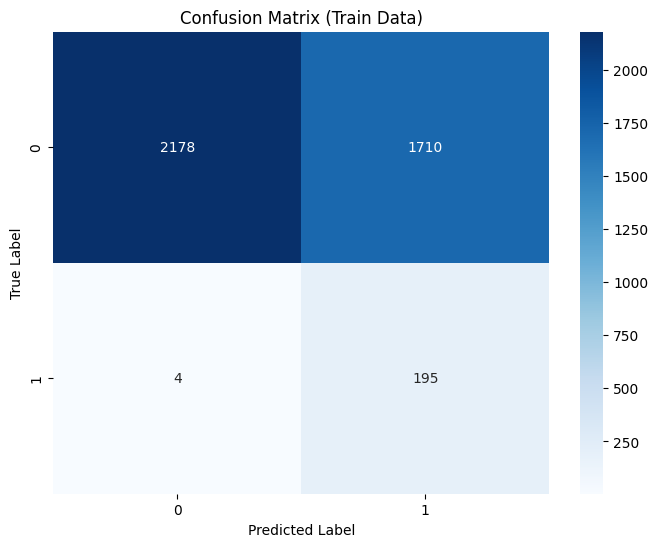

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 預測
y_pred = rcv.predict(X)

# 計算混淆矩陣
cm = confusion_matrix(y, y_pred)
labels = rcv.classes_  # pipeline 最後分類器的類別

# 用 seaborn 繪製熱力圖
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Train Data)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [15]:
import plotly.express as px
import pandas as pd
from sklearn.metrics import confusion_matrix

# 預測
y_pred = rcv.predict(X)

# 計算混淆矩陣
cm = confusion_matrix(y, y_pred)
labels = rcv.classes_  # pipeline 最後分類器的類別

# 轉成 DataFrame
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# 用 Plotly 畫熱力圖
fig = px.imshow(
    cm_df,
    text_auto=True,       # 顯示數字
    color_continuous_scale="Blues",
    labels=dict(x="Predicted Label", y="True Label", color="Count"),
)

fig.update_layout(
    title="Confusion Matrix (Train Data)",
    xaxis_title="Predicted Label",
    yaxis_title="True Label"
)

fig.show()

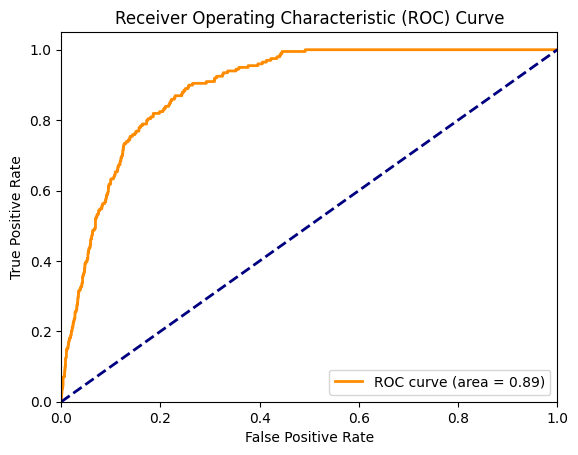

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 取得預測的機率 (預測為類別 1 的機率)
y_prob = rcv.predict_proba(X)[:, 1]

# 計算 ROC 曲線的 FPR, TPR, 和閾值
fpr, tpr, thresholds = roc_curve(y, y_prob)

# 計算 AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# 繪製 ROC 曲線
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [17]:
import gradio as gr
import pickle

f =  open("model.bin", "rb")
model =  pickle.load(f)

# 預測函式
def predict_stroke(gender, age, hypertension, heart_disease,
                   ever_married, work_type, residence_type,
                   avg_glucose_level, bmi, smoking_status):

    hypertension_val = 1 if hypertension == "有" else 0
    heart_disease_val = 1 if heart_disease == "有" else 0

    data_dict = {
        'gender': gender,
        'age': age,
        'hypertension': hypertension_val,
        'heart_disease': heart_disease_val,
        'ever_married': ever_married,
        'work_type': work_type,
        'residence_type': residence_type,
        'avg_glucose_level': avg_glucose_level,
        'bmi': bmi,
        'smoking_status': smoking_status
    }

    # 假設模型 predict 方法接受字典，並返回一個包含預測結果的 list
    prediction = model.predict(data_dict)

    if prediction[0] == 1:
        return "⚠️ 高風險 (可能有中風風險)"
    else:
        return "✅ 低風險 (中風風險較低)"

with gr.Blocks(title="🧑‍⚕️ 中風風險預測") as demo:
    gr.Markdown("## 🧑‍⚕️ 中風風險預測\n輸入基本健康資料，預測中風風險 (此為示範，非醫療建議)")

    with gr.Row():
        with gr.Column():
            gender = gr.Radio(["Male (男)", "Female (女)"], label="性別")
            age = gr.Number(label="年齡", maximum=100, minimum=1, step=1, value=30)
            hypertension = gr.Radio(["有", "無"], label="高血壓")
            heart_disease = gr.Radio(["有", "無"], label="心臟病")
            ever_married = gr.Radio(["有", "無"], label="是否結過婚")
        with gr.Column():
            work_type = gr.Dropdown(
                ["children (小孩)", "Govt_job (公務員)", "Never_worked (從未工作過)",
                 "Private (私人部門)", "Self-employed (自僱)"],
                label="工作類型"
            )
            residence_type = gr.Radio(["Rural (鄉村)", "Urban (城市)"], label="居住類型")
            avg_glucose_level = gr.Number(label="平均血糖值", maximum=300, minimum=50, step=10, value=100)
            bmi = gr.Number(label="BMI (體重指數)", maximum=100, minimum=10, step=1, value=22)
            smoking_status = gr.Dropdown(
                ["formerly smoked (曾經吸菸)", "never smoked (從未吸菸)",
                 "smokes (目前吸菸)", "Unknown (未知)"],
                label="吸菸狀態"
            )

    with gr.Row():
        submit_btn = gr.Button("預測中風風險", variant="primary")

    output = gr.Textbox(label="預測結果 (是否可能中風)", lines=2)

    submit_btn.click(
        predict_stroke,
        inputs=[gender, age, hypertension, heart_disease,
                ever_married, work_type, residence_type,
                avg_glucose_level, bmi, smoking_status],
        outputs=output
    )

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7176293ab53635303b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
